# Training the CNN with CIFAR-10

This notebook trains a CNN like ResNet-18 or LeNet5 with the CIFAR-10 dataset in a deterministic fashion and stores the obtained weights.

### 0. Import libraries and define settings

In [7]:
# import Python packages
import os
import time
import random
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

# import custom Python modules
import utils
from data_loader import DataLoader
from resnet_architecture import ResNet
from lenet_architecture import Net

# allow to automatically update the imported modules
%load_ext autoreload
%autoreload 2

sns.set()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# get cuda or cpu device for training
device = utils.get_device()


Currently using: cuda


In [9]:
# make PyTorch deterministic
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"


In [10]:
# define paths and model name
MODEL_PATH = "model/"
MODEL_NAME = "baseline_lenet5_100_epochs.pth"


### 1. Load and preprocess data

In [11]:
data_loader = DataLoader()
trainset, trainloader = data_loader.load_train_data()
testset, testloader = data_loader.load_test_data()


100%|██████████| 170498071/170498071 [00:04<00:00, 41663714.26it/s]


Extracting ../../data/raw_dataset/cifar-10-python.tar.gz to ../../data/raw_dataset/
Files already downloaded and verified


### 2. Train the network

In [12]:
# instantiate the network
net = Net().to(device) #ResNet().to(device)

# define the loss function
criterion = nn.CrossEntropyLoss()

# declare the optimization function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


In [13]:
# initialize the timer
start = time.time()

# define lists that store train and test accuracy for each epoch
train_acc = []
test_acc = []

for epoch in tqdm(range(0, 100)):

    # initialize number of correct train predictions for the current epoch
    correct_train_total = 0

    net.train()  # Put the network in train mode
    for i, (x_batch, y_batch) in enumerate(trainloader):
        # Move the data to the device that is used
        x_batch, y_batch = x_batch.to(device), y_batch.to(
            device
        )

        # Set all currenly stored gradients to zero
        optimizer.zero_grad()

        y_pred = net(x_batch)

        # compute loss
        loss = criterion(y_pred, y_batch)

        # backpropagate gradients
        loss.backward()

        # apply the optimization step
        optimizer.step()

        # Get the labels with highest output probability
        y_pred_max = torch.argmax(
            y_pred, dim=1
        )

        # Count how many are equal to the true labels
        correct = torch.sum(
            torch.eq(y_pred_max, y_batch)
        ).item()

        # Keep track of how much time has elapsed
        elapsed = time.time() - start

        # Accumulate number of correct predictions
        correct_train_total += correct

        correct_total = 0

    # store train accuracy for current epoch
    train_acc.append(correct_train_total / len(trainset))

    # Put the network in eval mode
    net.eval()

    for i, (x_batch, y_batch) in enumerate(testloader):
        # Move the data to the device that is used
        x_batch, y_batch = x_batch.to(device), y_batch.to(
            device
        )

        # count number of correct predictions
        y_pred = net(x_batch)
        y_pred_max = torch.argmax(y_pred, dim=1)

        correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

    # store test accuracy for current epoch
    test_acc.append(correct_total / len(testset))


100%|██████████| 100/100 [28:20<00:00, 17.01s/it]


### 3. Visualize performance

Train accuracy: 0.9284
Test accuracy: 0.5152


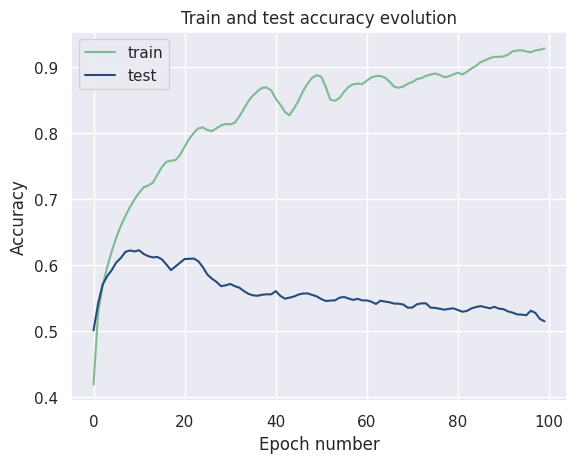

In [17]:
plt.plot(range(len(train_acc)), train_acc, color=(0.48942421, 0.72854938, 0.56751036))
plt.plot(range(len(test_acc)), test_acc, color=(0.14573579, 0.29354139, 0.49847009))
plt.legend(["train", "test"])
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.title("Train and test accuracy evolution")

print(f"Train accuracy: {train_acc[-1]}\nTest accuracy: {test_acc[-1]}")
plt.savefig("./baseline_lenet5_100_epochs.png", dpi=300)

### 4. Store model

In [15]:
# create a folder for storing the models
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# store the trained model
torch.save(net.state_dict(), MODEL_PATH + MODEL_NAME)
